In [1]:
from ipynb.fs.full.data_cleaning import df
import numpy as np
from numpy import NaN
import matplotlib
import matplotlib.pyplot as plt

df.sample(5)

,Segments,Services,Type,Service,Hires,Price,Price Type,Rating,Zip Code,Capital City,State,Abbreviation,Implied Revenue
71724,Home Improvement,Circuit Breaker Panel or Fuse Box Installation,Peripheral,High Voltage Electrical,69.00,NaN,,5.00,92101,San Diego,California,CA,NaN
66531,Home Improvement,Brick or Stone Repair,Peripheral,"Henry Group, LLC",36.00,NaN,,5.00,28105,Charlotte,North Carolina,NC,NaN
172,Business,Business Tax Preparation,Main,David Beck CPA,382.00,350.00,,4.50,7102,Newark,New Jersey,NJ,"133,700.00"
70746,Home Improvement,Concrete Installation,Peripheral,Arizona Discount Flooring Specialists,87.00,NaN,,4.50,85001,Phoenix,Arizona,AZ,NaN
63422,Home Improvement,Carpet Installation,Peripheral,Quality Flooring,2.00,NaN,,2.50,32202,Jacksonville,Florida,FL,NaN


In [2]:
df.shape

(17440, 13)

**General quetions:**
1. Which segments is Thumbtack focusing on? Or is Thumbtack consistent in all segments & services?
2. Does the demand & supply in services change from a region to another?
3. Which segments are doing better or worse?
4. Is Thumbtack offering this many services because they have a low # hires/# sellers rate?
5. Are there any segments or services that showcase more uncaptured potential?
6. What types of sellers are the most successful? Individuals or business? Does it depend on the type of service and/or region?

**1. Which segments is Thumbtack focusing on?**

We can first see a basic count of services for each segment

In [3]:
# See ranking by count
segmentCount = df.groupby("Segments")["Segments"].count()
dfSegmentCount = segmentCount.to_frame(name="Count").reset_index()
dfSegmentCount[
    "Contribution"] = dfSegmentCount["Count"] / dfSegmentCount["Count"].sum()
dfSegmentCount.sort_values(by="Count", ascending=False)

,Segments,Count,Contribution
2,Home Improvement,9079,0.52
1,Events,3486,0.20
5,Wellness,1595,0.09
3,Lessons,1493,0.09
0,Business,1254,0.07
4,Pets,533,0.03


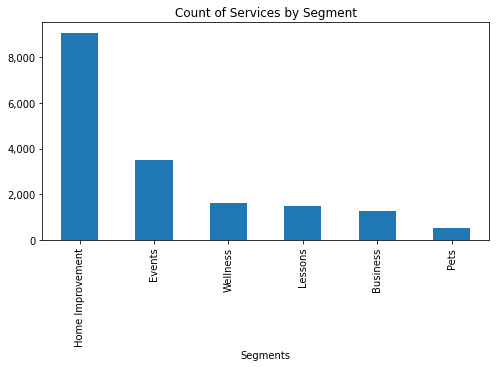

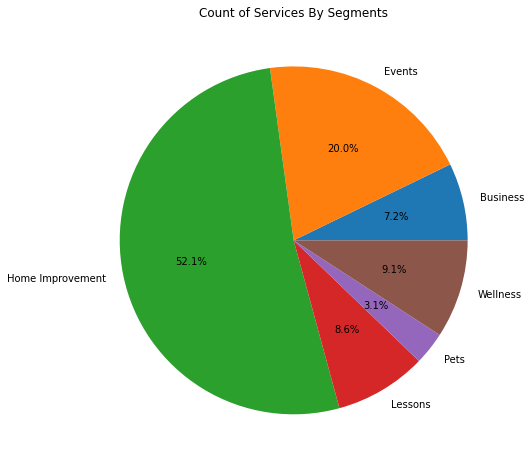

In [20]:
segmentCount.sort_values(ascending=False).plot.bar(
    title="Count of Services by Segment", figsize=(8,4))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

segmentCount.plot.pie(autopct="%.1f%%",
                      title="Count of Services By Segments",
                      y="Count",
                      ylabel="",
                      figsize=(8, 8))
plt.show()

In [5]:
# See ranking by count
servicesCount = df.groupby("Services")["Services"].count()
dfServicesCount = servicesCount.to_frame(name="Count").reset_index()
dfServicesCount[
    "Contribution"] = dfServicesCount["Count"] / dfServicesCount["Count"].sum()
dfServicesCount.sort_values(by="Count", ascending=False)[:19]

,Services,Count,Contribution
63,Roof Repair or Maintenance,860,0.05
78,Wedding Officiant,839,0.05
33,Commercial Cleaning,836,0.05
1,Accounting,791,0.05
31,Closet and Shelving System Installation,782,0.04
80,Wedding and Event Makeup,712,0.04
48,Massage Therapy,697,0.04
39,DJ,684,0.04
44,Interior Design,627,0.04
43,House Cleaning,507,0.03


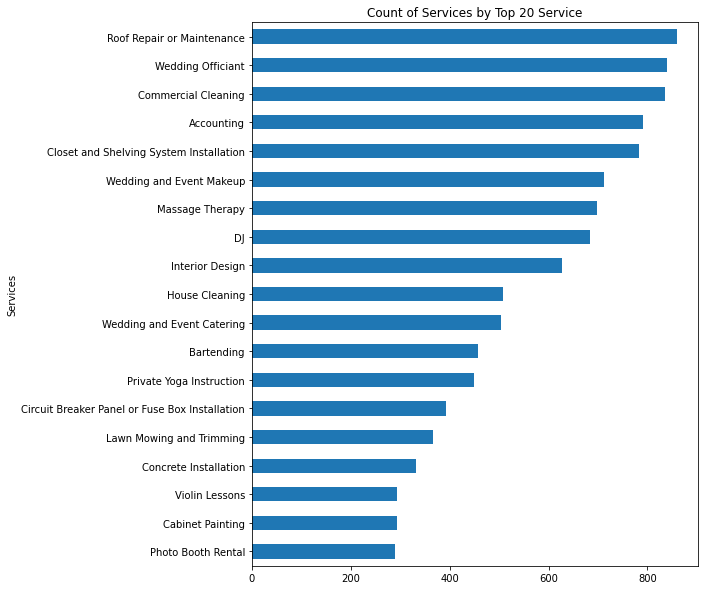

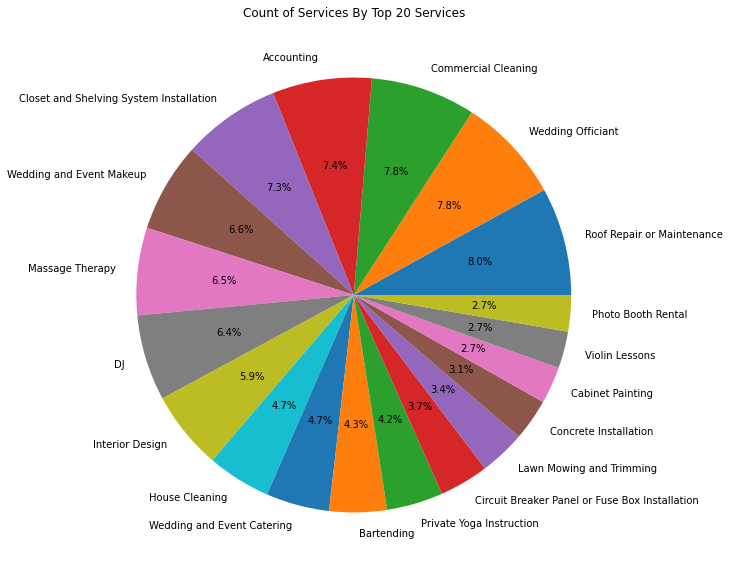

In [6]:
servicesCountChart = servicesCount.sort_values(ascending=False)[:19]
servicesCountChart.sort_values(ascending=True).plot.barh(
    title="Count of Services by Top 20 Service", xlabel="Services", figsize=(8, 10))
plt.show()

servicesCountChart.plot.pie(autopct="%.1f%%",
                            title="Count of Services By Top 20 Services",
                            y="Count",
                            ylabel="",
                            figsize=(10, 10))
plt.show()

Then we can maybe see implied revenue from these segments

In [7]:
# Get sum of implied revenue by segment
dfRevenuBySegment = df.groupby("Segments")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuBySegment["Contribution"] = dfRevenuBySegment[
    "Implied Revenue"] / dfRevenuBySegment["Implied Revenue"].sum()

# Get sum of implied revenue by services
dfRevenuByServices = df.groupby("Services")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuByServices["Contribution"] = dfRevenuByServices[
    "Implied Revenue"] / dfRevenuByServices["Implied Revenue"].sum()

# Get sum of implied revenue by states
dfRevenuByRevenue = df.groupby("State")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuByRevenue["Contribution"] = dfRevenuByRevenue[
    "Implied Revenue"] / dfRevenuByRevenue["Implied Revenue"].sum()

In [8]:
# See implied revenue by segment
dfRevenuBySegment.sort_values(by="Contribution", ascending=False)

,Segments,Implied Revenue,Contribution
2,Home Improvement,"24,532,162.00",0.43
1,Events,"21,770,915.00",0.39
0,Business,"4,122,263.00",0.07
5,Wellness,"3,562,406.00",0.06
3,Lessons,"2,172,309.00",0.04
4,Pets,"304,754.00",0.01


In [9]:
# See top 10 implied revenue by services
dfRevenuByServices.sort_values(by="Contribution", ascending=False)[:9]

,Services,Implied Revenue,Contribution
78,Wedding Officiant,"9,046,401.00",0.16
39,DJ,"5,589,660.00",0.10
53,Photo Booth Rental,"3,617,129.00",0.06
14,Bed Bug Extermination,"3,336,025.00",0.06
32,Commercial Carpet Cleaning,"3,195,400.00",0.06
33,Commercial Cleaning,"2,424,420.00",0.04
48,Massage Therapy,"2,149,258.00",0.04
28,Circuit Breaker Panel or Fuse Box Installation,"2,068,216.00",0.04
80,Wedding and Event Makeup,"1,802,999.00",0.03


In [10]:
# See top 10 implied revenue by zipcode
dfRevenuByRevenue.sort_values(by="Contribution", ascending=False)[:9]

,State,Implied Revenue,Contribution
4,California,"7,697,235.00",0.14
43,Texas,"5,754,376.00",0.10
9,Florida,"3,624,092.00",0.06
30,New Jersey,"2,783,597.00",0.05
32,New York,"2,260,447.00",0.04
5,Colorado,"2,013,176.00",0.04
10,Georgia,"2,008,146.00",0.04
25,Missouri,"1,950,559.00",0.03
33,North Carolina,"1,873,903.00",0.03


**2. Does the demand & supply in services change from a region to another?**

Outputs per regional segments & services:
- \# services
- \# hires
- \# hires/#services rate
- List of sellers per region

**3. Which segments are doing better or worse?**

**4. Is Thumbtack offering this many services because they have a low #hires/#sellers rate?**

**5. Are there any segments or services that showcase more uncaptured potential?**

**6. What types of sellers are the most successful? Individuals or business? Does it depend on the type of service and/or region?**